My previous out-of-my-ass bounds violated my own constratins and generally led to unphysial galaxy distributions. In this notebook I pursue a more optimal set of boundaries. 

In [483]:
#from pearce.emulator import SpicyBuffalo, LemonPepperWet, OriginalRecipe
#from pearce.mocks import cat_dict
import numpy as np
from os import path

In [484]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [485]:
em_method = 'gp'
split_method = 'random'

In [486]:
bin_idx = 0
#fixed_params = {'z':z, 'r': 0.09581734}#, 'cosmo': 0}#, 'r':24.06822623}

In [487]:
from pearce.mocks.kittens import TrainingBox

In [488]:
boxno = 0
cat = TrainingBox(boxno, system = 'sherlock')

In [489]:
cat.load(1.0, HOD='zheng07')

In [490]:
nd = 5e-4

In [491]:
hod_pnames = ['logM0', 'sigma_logM', 'logM1', 'alpha']
mf = cat.calc_mf()

In [492]:
from itertools import product

In [493]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat):
    """
    In the fixed number density case, find the logMmin value that will match the nd given hod_params
    :param: hod_params:
        The other parameters besides logMmin
    :param cat:
        the catalog in question
    :return:
        None. hod_params will have logMmin added to it.
    """
    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        #print logMmin
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params) - nd)**2

    res = minimize_scalar(func, bounds = (12.0, 16.0), args = (hod_params,), options = {'maxiter':1000},\
                          method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x
    #print 
    #print hod_params

In [494]:
cat.calc_analytic_nd()

0.001827839524404642

In [495]:
lower_bounds = [12.6, 0.05, 13.7, 0.7]
upper_bounds = [13.6, 0.5, 14.7, 1.3]
# prev vals
#lower_bounds = [13.1, 0.05, 13.1, 0.8]
#upper_bounds = [14.6, 0.3, 14.6, 1.2]
bounds = zip(lower_bounds, upper_bounds)

params_arr = np.array([list(p) for p in product(*bounds)])

In [496]:
sat_nd = np.zeros((params_arr.shape[0],))
actual_nd = np.zeros_like(sat_nd)
log_mMins = np.zeros_like(sat_nd)

for idx, p in enumerate(params_arr):
    hod_params = dict(zip(hod_pnames, p))
    add_logMmin(hod_params, cat)
    log_mMins[idx] = hod_params['logMmin']
    sat_hod = cat.calc_hod(hod_params, component='satellite')
    sat_nd[idx] = np.sum(mf*sat_hod)/((cat.Lbox)**3)#/cat.h)**3)
    #sat_fracs[idx] = sat_nd/nd
    cen_hod = cat.calc_hod(hod_params, component='central')
    actual_nd[idx] = np.sum(mf*(cen_hod+sat_hod))/((cat.Lbox)**3)#cat.calc_analytic_nd(hod_params)#/cat.h**3
    
sat_fracs = sat_nd/actual_nd

logMmin 13.6253832426
logMmin 13.76492952
logMmin 13.1204592664
logMmin 13.0688108091
logMmin 13.7710410426
logMmin 13.9212537276
logMmin 13.1370786294
logMmin 13.0422450522
logMmin 13.1604979549
logMmin 13.2725991941
logMmin 13.0705021104
logMmin 13.0594809746
logMmin 13.2018751161
logMmin 13.3606778377
logMmin 13.0456093464
logMmin 13.0233099333


In [497]:
print np.min(sat_fracs), np.max(sat_fracs)

0.0210949193203 0.852495522033


In [498]:
print sorted(sat_fracs)

[0.021094919320288497, 0.021094925915044378, 0.042725960430079174, 0.042725966115552003, 0.046603309760311573, 0.046603317067639316, 0.15500548114081417, 0.15500568004872467, 0.23357000238111633, 0.23357015265165629, 0.42089894019654078, 0.4208991933685014, 0.77686755466989132, 0.77686776201874153, 0.85249471465896953, 0.85249552203279799]


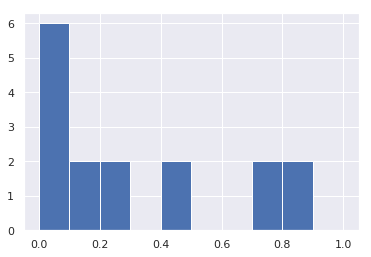

In [499]:
plt.hist(sat_fracs, bins = np.linspace(0, 1, 11));

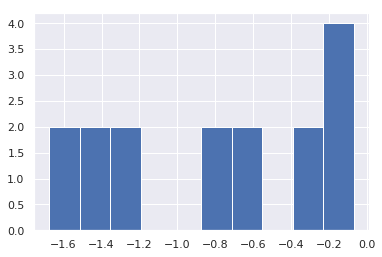

In [500]:
plt.hist(np.log10(sat_fracs));

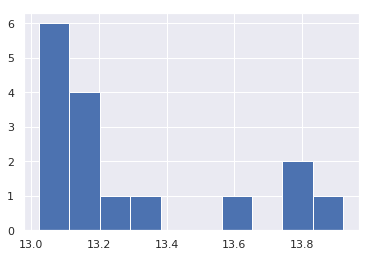

In [501]:
plt.hist(log_mMins);

In [502]:
hod_pnames

['logM0', 'sigma_logM', 'logM1', 'alpha']

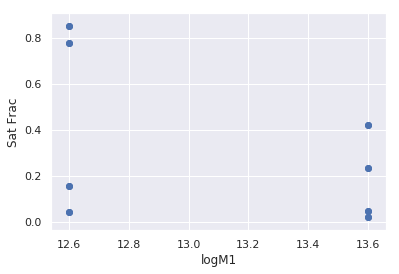

In [503]:
plt.scatter(params_arr[:,0], sat_fracs)
plt.xlabel('logM1')
plt.ylabel('Sat Frac')

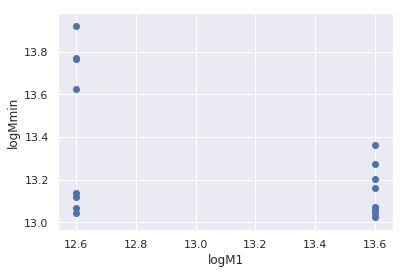

In [504]:
plt.scatter(params_arr[:,0], log_mMins)
plt.xlabel('logM1')
plt.ylabel('logMmin')

(array([ 2.,  0.,  0.,  1.,  2.,  1.,  3.,  5.,  1.,  1.]),
 array([ -5.95987145e-06,  -5.03457018e-06,  -4.10926891e-06,
         -3.18396764e-06,  -2.25866637e-06,  -1.33336510e-06,
         -4.08063824e-07,   5.17237447e-07,   1.44253872e-06,
          2.36783999e-06,   3.29314126e-06]),
 <a list of 10 Patch objects>)

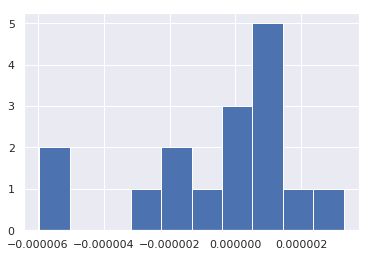

In [505]:
plt.hist(1e4*(actual_nd-nd) )

In [506]:
actual_nd

array([ 0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,  0.0005,
        0.0005,  0.0005])

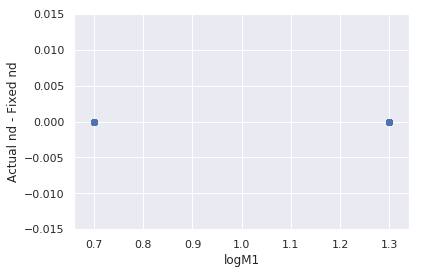

In [507]:
plt.scatter(params_arr[:,3], 1e4*(actual_nd-nd) )
plt.xlabel('logM1')
plt.ylabel('Actual nd - Fixed nd')

In [508]:
print params_arr[np.abs(actual_nd-nd)>1e-6, :]

[]


In [509]:
actual_nd-nd

array([  1.28158241e-10,   3.29314126e-10,   4.56278219e-11,
         1.02948446e-10,  -5.29362372e-12,  -1.44221710e-10,
        -5.95987145e-10,   1.69482632e-10,  -5.71676817e-10,
         1.41939922e-10,   9.98243596e-11,   9.99176347e-11,
        -2.49995166e-10,  -1.58811466e-10,   2.14251205e-11,
        -5.63938220e-11])